In [ ]:
import h5py
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [17]:
def inspect_euler_hdf5(file_path):
    """
    Inspect an Euler periodicBC HDF5 file safely.

    Args:
        file_path (str or Path): path to .hdf5 file
    """
    file_path = Path(file_path)
    print(f"Inspecting file: {file_path}\n")

    with h5py.File(file_path, "r") as f:
        # List top-level groups and datasets
        for g_name, obj in f.items():
            print(f"- Group: {g_name}")
            for obj_name, child in obj.items():
                if isinstance(child, h5py.Dataset):
                    # print dataset info
                    try:
                        print(f"    - Dataset: {obj_name}, shape={child.shape}, dtype={child.dtype}")
                    except Exception:
                        print(f"    - Dataset: {obj_name}, shape={child.shape}")
                elif isinstance(child, h5py.Group):
                    # child is a subgroup
                    print(f"    - Subgroup: {obj_name}")
                    # List datasets in subgroup
                    for sub_name, sub_child in child.items():
                        print(f"        - Dataset: {sub_name}, shape={sub_child.shape}, dtype={sub_child.dtype}")

file_path = "/scratch/izar/boscario/datasets/euler_multi_quadrants_periodicBC/data/train/euler_multi_quadrants_periodicBC_gamma_1.76_Ar_-180.hdf5"
inspect_euler_hdf5(file_path)

Inspecting file: /scratch/izar/boscario/datasets/euler_multi_quadrants_periodicBC/data/train/euler_multi_quadrants_periodicBC_gamma_1.76_Ar_-180.hdf5

- Group: boundary_conditions
    - Subgroup: x_periodic
        - Dataset: mask, shape=(512,), dtype=bool
    - Subgroup: y_periodic
        - Dataset: mask, shape=(512,), dtype=bool
- Group: dimensions
    - Dataset: time, shape=(101,)
    - Dataset: x, shape=(512,)
    - Dataset: y, shape=(512,)
- Group: scalars
    - Dataset: gamma, shape=()
- Group: t0_fields
    - Dataset: density, shape=(400, 101, 512, 512)
    - Dataset: energy, shape=(400, 101, 512, 512)
    - Dataset: pressure, shape=(400, 101, 512, 512)
- Group: t1_fields
    - Dataset: momentum, shape=(400, 101, 512, 512, 2)
- Group: t2_fields


Based on the output, we know each .hdf5 file contains 6 groups:

- `boundary_conditions`
    - sub-group: `x_periodic`
        - dataset: `mask`
    - sub-group: `y_periodic`
        - dataset: `mask`
- `dimensions`
    - dataset: `time`
    - dataset: `x`
    - dataset: `y`
- `scalars`
    - dataset: `gamma`
- `t0_fields`
    - dataset: `density`
    - dataset: `energy`
    - dataset: `pressure`
- `t1_fields`
    - dataset: `momentum`
- `t2_fields`

Each `.hdf5` file in the train split has 400 simulations, while in the valid and test splits there are 50 simulations. The time horizon is always 101 timesteps and the grid is a uniform 512x512.

Since the datasets store numerical values in a weird format, slicing cannot be performed as usual. For example:

```python
d_density = f["t0_fields/density"]

# then, one cannot do:
density_sim0_t0 = d_density[0, 0, :, :]

# MUST use .read_direct:
src_sel_scalar = np.s_[0, 0, :, :]
tmp = np.empty((H, W), dtype=np.float32)
d_density.read_direct(tmp, source_sel=src_sel_scalar)
```

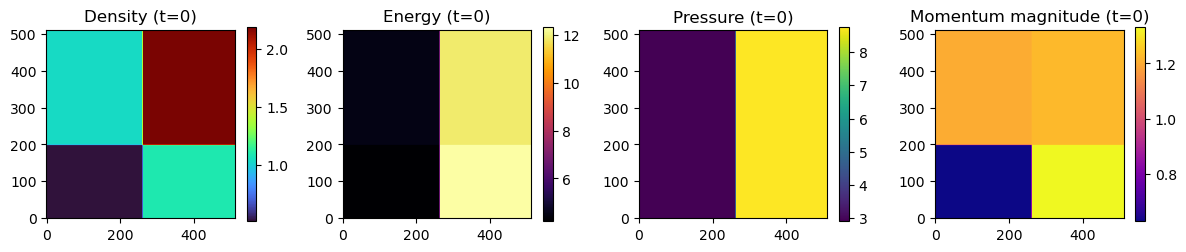

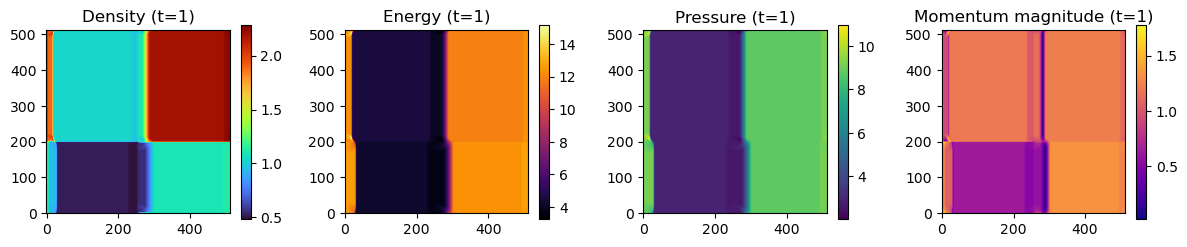

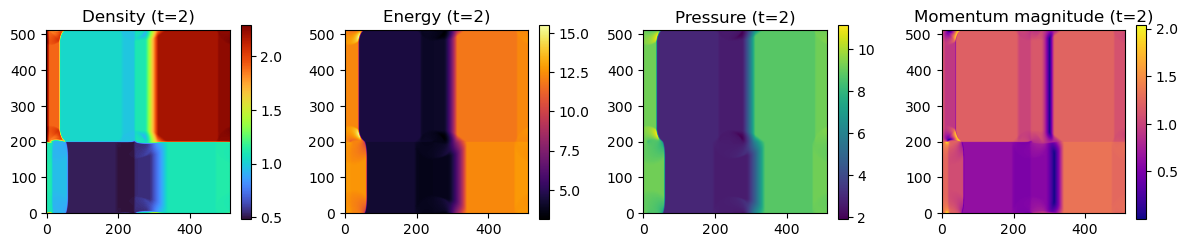

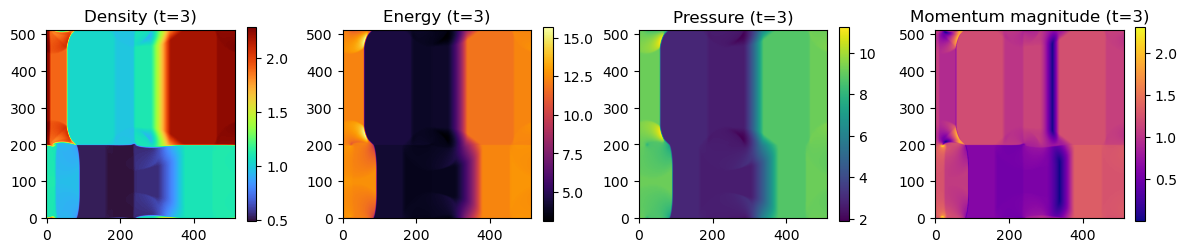

In [40]:
def load_slice_and_plot(h5_path, sim_idx=0, t=4):
    """
    Load a small time slice (safe) from the Euler HDF5 and plot fields.

    Args:
        h5_path (str or Path): path to .hdf5 file
        sim_idx (int): which simulation index to read (0..399)
        t (int): number of timesteps to read (0..100)
    """
    h5_path = Path(h5_path)
    with h5py.File(h5_path, "r") as f:
        # dataset handles
        d_density = f["t0_fields/density"]
        d_energy  = f["t0_fields/energy"]
        d_pressure= f["t0_fields/pressure"]
        d_mom     = f["t1_fields/momentum"]

        H, W = d_density.shape[2], d_density.shape[3]

        # preallocate arrays (t, H, W)
        density = np.empty((t, H, W), dtype=np.float32)
        energy  = np.empty((t, H, W), dtype=np.float32)
        pressure= np.empty((t, H, W), dtype=np.float32)
        momentum= np.empty((t, H, W, 2), dtype=np.float32)

        # read each dataset with read_direct using source_sel hyperslabs
        for i in range(t):
            # source selection is (sim_idx, t_idx, :, :) for scalar t0_fields
            # use np.s_ to create slice objects
            src_sel_scalar = np.s_[sim_idx, i, :, :]    # equivalent to (slice(sim_idx,i,None), slice(None), slice(None))
            tmp = np.empty((H, W), dtype=np.float32)

            d_density.read_direct(tmp, source_sel=src_sel_scalar); density[i] = tmp
            d_energy.read_direct(tmp, source_sel=src_sel_scalar);  energy[i]  = tmp
            d_pressure.read_direct(tmp, source_sel=src_sel_scalar);pressure[i]= tmp

            # momentum has last channel of size 2
            src_sel_vector = np.s_[sim_idx, i, :, :, :]  # equivalent to (slice(sim_idx,i,None), slice(None), slice(None), slice(None))
            tmpm = np.empty((H, W, 2), dtype=np.float32)
            d_mom.read_direct(tmpm, source_sel=src_sel_vector); momentum[i] = tmpm

    # compute momentum magnitude
    mom_mag = np.sqrt(momentum[:, :, :, 0]**2 + momentum[:, :, :, 1]**2)

    # Plotting: one 1x4 grid per timestep
    for i in range(t):
        fig, ax = plt.subplots(1, 4, figsize=(12,10))

        im0 = ax[0].imshow(density[i], origin="lower", cmap='turbo')
        ax[0].set_title(f"Density (t={i})")
        fig.colorbar(im0, ax=ax[0], shrink=0.2)

        im1 = ax[1].imshow(energy[i], origin="lower", cmap='inferno')
        ax[1].set_title(f"Energy (t={i})")
        fig.colorbar(im1, ax=ax[1], shrink=0.2)

        im2 = ax[2].imshow(pressure[i], origin="lower", cmap='viridis')
        ax[2].set_title(f"Pressure (t={i})")
        fig.colorbar(im2, ax=ax[2], shrink=0.2)

        im3 = ax[3].imshow(mom_mag[i], origin="lower", cmap='plasma')
        ax[3].set_title(f"Momentum magnitude (t={i})")
        fig.colorbar(im3, ax=ax[3], shrink=0.2)

        plt.tight_layout()
        plt.show()
 
# Usage
file_path = "/scratch/izar/boscario/datasets/euler_multi_quadrants_periodicBC/data/train/euler_multi_quadrants_periodicBC_gamma_1.76_Ar_-180.hdf5"
load_slice_and_plot(file_path)


In [66]:
with h5py.File(file_path, "r") as f:
    bcs = f["boundary_conditions"]["x_periodic"]["mask"]
    print(bcs)
    print(bcs.shape)
    print(bcs.dtype)
    bcs = list(bcs)
    print(bcs)
    # sum all elements
    print(f"Sum of all elements: {sum(bcs)}")

    bcs = f["boundary_conditions"]["y_periodic"]["mask"]
    print(bcs)
    print(bcs.shape)
    print(bcs.dtype)
    bcs = list(bcs)
    print(bcs)
    # sum all elements
    print(f"Sum of all elements: {sum(bcs)}")

<HDF5 dataset "mask": shape (512,), type "|b1">
(512,)
bool
[True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, Fa